# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>3) Grid Search</b>  

___

## <b>Table of Content</b> <a id="toc_"></a>

* [Training Window Length](#trainwindow)  
* [Top-n Ports for Auto Defined Services](#topn)  
    * [Single Training](#topn:single)  
    * [incremental Training](#topn:incremental)  
* [k of k-NN Classifier](#knofknn)
* [Without Duplicates and Incremental Training](#duplicatesincremental)
* [Word2Vec Parameters](#word2vec)
* [Best Cases](#final)  

Notebook description

___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

***Note:*** Be aware that these script require a large amount of time for training all models tested in the paper.

In [1]:
DEMONSTRATIVE = False

In [2]:
from config import *
from src.word2vec import Word2Vec
from src.preprocess import load_raw_data, filter_data
from src.preprocess import get_next_day, get_prev_day
from src.knnClassifier import *
from src.utils import *
from src.callbacks import *

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances as distances
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler
plt.rcParams["font.family"] = "serif"

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
### <b>Prerequisites</b> <a name="trainwindow"></a>



In [4]:
# Load last day of traffic
raw_data = load_raw_data('20210331')
filtered = filter_data(raw_data, '20210331')

print(filtered.shape)
filtered.head(3)

(3403919, 6)


,ts,ip,port,proto,pck_len,pp
ts,,,,,,
2021-03-30 22:29:08.691001,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.691010,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.811067,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp


In [66]:
# Load the ground truth
gt = pd.read_csv('../ground_truth/big_gt.csv')
ips = filtered.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
gt2 = pd.read_csv(MANUAL_GT).rename(columns={'gt':'class'})
gt2 = gt2[~gt2['class'].isin(['bitsight', 'shadowserver.org', 'unknown'])]
gt2 = gt2[~gt2.ip.isin(gt.ip)]
gt = pd.concat([gt, gt2])
"""
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})
"""
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown')
freqs = lookup.value_counts('class')
freqs = freqs[freqs>=10].index
idx = lookup[~lookup['class'].isin(freqs)].index
lookup.loc[idx, 'class'] = 'unknown'
print(lookup.shape)
lookup.head(3)

(22765, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


In [35]:
mlist = [('auto', 5, 200)]
snames = {'ss':'Single', 'dk':'Domain Knowledge Based',
          'auto':'Auto Defined', 'hybrid':'Hybrid'}
for service, c, e in mlist:
    model_path_name = f'model_gs_{service}_c{c}_e{e}'
    w2v = Word2Vec(mname=f'{MODELS}/gridsearch/{model_path_name}')
    w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)

    knn = KnnClassifier(embeddings, 5)
    knn.fit_predict()
    knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
    report = knn.get_report(output_dict=False, labels=knnlabels)
    
    print(report)

                precision    recall  f1-score   support

        shodan       1.00      0.96      0.98        51
        censys       0.99      1.00      1.00       328
          ipip       1.00      0.57      0.73        49
    netsystems       1.00      1.00      1.00        94
internetcensus       0.99      0.99      0.99        97
    binaryedge       1.00      0.68      0.81        25
   alphastrike       1.00      0.87      0.93       281
  shadowserver       1.00      1.00      1.00       574
        u_mich       1.00      1.00      1.00        20

     micro avg       1.00      0.95      0.98      1519
     macro avg       1.00      0.90      0.94      1519
  weighted avg       1.00      0.95      0.97      1519



In [67]:
mlist = [('auto', 5, 200)]
snames = {'ss':'Single', 'dk':'Domain Knowledge Based',
          'auto':'Auto Defined', 'hybrid':'Hybrid'}
for service, c, e in mlist:
    model_path_name = f'model_gs_{service}_c{c}_e{e}'
    w2v = Word2Vec(mname=f'{MODELS}/gridsearch/{model_path_name}')
    w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)

    knn = KnnClassifier(embeddings, 5)
    knn.fit_predict()
    knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
    report = knn.get_report(output_dict=False, labels=knnlabels)
    
    print(report)

                       precision    recall  f1-score   support

           mirai-like       1.00      0.98      0.99      7350
               shodan       0.96      0.96      0.96        54
               censys       0.98      1.00      0.99       336
                 ipip       0.80      0.57      0.67        49
            sharashka       1.00      1.00      1.00        50
           netsystems       1.00      1.00      1.00        94
       internetcensus       0.99      0.99      0.99        97
           stretchoid       1.00      0.24      0.39       104
           binaryedge       0.98      0.99      0.99       121
          alphastrike       0.89      0.84      0.87       281
         shadowserver       1.00      1.00      1.00       574
               u_mich       1.00      1.00      1.00        20
cloud system networks       1.00      1.00      1.00        46

            micro avg       0.99      0.97      0.98      9176
            macro avg       0.97      0.89      0.91 

In [8]:
# Load the final model
model_path_name = f'word2vec_auto_c5_e200'
w2v = Word2Vec(mname=f'{MODELS}/word2vec/{model_path_name}')
w2v.load_model()
# Retrieve the embeddings
embeddings = w2v.get_embeddings(ips, lookup)

print(embeddings.shape)
embeddings.head(3)

(22399, 201)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
ip,,,,,,,,,,,,,,,,,,,,,
201.166.132.114,-0.311996,-0.151880,-0.126155,-0.072640,-0.178640,0.024080,-0.022133,0.057160,-0.323721,0.022568,...,0.283371,0.126785,0.275466,0.114976,0.073976,-0.138251,0.262670,-0.148449,-0.197116,unknown
172.245.10.231,-1.256613,-1.317889,-0.910986,-0.773604,-1.041731,0.157510,-0.035242,-0.574435,-0.953921,-0.234043,...,0.120722,0.061658,0.289806,0.052150,0.272534,0.037336,0.426259,-0.294904,0.005054,unknown
119.237.180.88,-0.090121,-0.085896,0.007295,-0.115396,-0.096167,0.018933,-0.014268,0.004455,-0.023784,0.002346,...,0.032283,0.021382,0.159330,0.020799,0.031832,-0.078330,0.073449,0.004153,-0.060807,unknown


In [11]:
if not DEMONSTRATIVE:
    X = embeddings.drop(columns=['class'])
else:
    X = embeddings.iloc[:500].drop(columns=['class'])
dist = distances(X, X, metric='cosine')

tsne = TSNE(n_components=2, random_state=15, metric='precomputed').fit_transform(dist)
df = pd.DataFrame(tsne, columns=['x', 'y'])
if not DEMONSTRATIVE:
    df.to_csv(f'{DATASETS}/tsne.csv')

<Figure size 640x480 with 0 Axes>

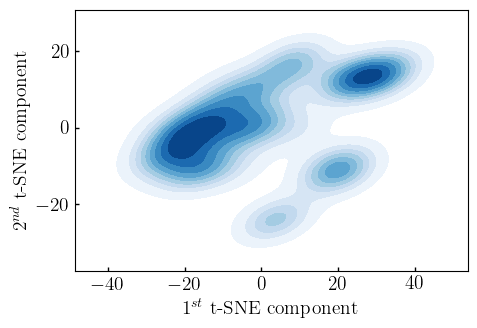

In [12]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: densityPlot(plt, df),
                      figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/density_kde.pdf')
plot.show()